### 코드 리팩토링 및 가독성 개선

기존에 작성한 MNIST 분류 예제 코드를 다시 보고, 읽기 쉽도록 정리합니다.

변수와 함수 이름을 명확하게 하고, 불필요한 중복 코드를 제거하며, 적절한 주석을 추가해 코드를 모듈화하는 연습을 합니다.

## 디버깅 기법 및 에러 해결

학습 과정이나 코드 실행 중에 발생할 수 있는 에러를 분석하고, 이를 해결하는 방법을 배웁니다.

에러 메시지 분석, print문이나 로깅, breakpoint 등을 활용하는 방법을 익힙니다.

## 미니 배치 학습 최적화

DataLoader의 batch_size, shuffle, num_workers 등의 옵션을 조절하여 학습 속도와 모델 성능에 미치는 영향을 실험합니다.

배치 크기에 따른 메모리 사용과 학습 시간의 관계를 분석하고, 최적의 설정을 찾는 방법을 배우겠습니다.

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
#def 

In [29]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1=nn.Linear(28*28,128)
        self.fc2=nn.Linear(128,10)

    def forward(self,x):
        x=x.view(-1,28*28)
        x=f.relu(self.fc1(x))
        x=self.fc2(x)
        return x


In [31]:
def train(model,train_loader, criter, optim, num_epoch=5):
    loss_history=[]
    for epoch in range(num_epoch):
        model.train()
        total_loss=0.0
        for banch_idx,(data,target) in enumerate(train_loader):
            optim.zero_grad()# 이전 배치의 gradient 초기화
            out=model(data)# forward pass로 예측값 계산
            loss=criter(out,target)# 손실 계산 (예: CrossEntropyLoss)
            loss.backward() # backward pass로 gradient 계산
            optim.step()  # 파라미터 업데이트
            total_loss+=loss.item() # 배치 손실을 누적

        avg_loss=total_loss/len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epoch}, Training Loss: {avg_loss:.4f}")
    return loss_history

model.train():
모델을 학습 모드로 전환하여 dropout이나 배치 정규화가 학습용으로 동작하게 합니다.

optimizer.zero_grad():
이전 배치의 gradient가 남아있지 않도록 초기화합니다.

loss.backward() & optimizer.step():
손실로부터 계산된 gradient를 이용해 모델 파라미터를 업데이트합니다.

loss_history:
각 에폭마다의 평균 손실을 기록해 학습 추이를 확인할 수 있도록 합니다.

In [34]:
def evals(model, test_loader):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for data,target in test_loader: # 평가 시 gradient 계산 비활성화 -> 메모리와 속도 최적화
            out=model(data)
            pred=out.argmax(dim=1, keepdim=True)  # 각 샘플마다 가장 높은 값을 갖는 인덱스 선택
            correct+=pred.eq(target.view_as(pred)).sum().item()
            total+=data.size(0)

    accuracy=100.0*correct/total
    return accuracy

model.eval():
평가 모드로 전환하여 dropout 등의 학습 전용 기능을 비활성화합니다.

torch.no_grad():
평가 중에는 gradient 계산이 필요 없으므로 메모리 사용을 줄이고 속도를 높입니다.

output.argmax(dim=1, keepdim=True):
각 샘플에 대해 가장 높은 값(예측된 클래스)의 인덱스를 선택합니다.

pred.eq(target.view_as(pred)):
예측 결과와 실제 정답이 일치하는지 element-wise 비교합니다.

In [37]:
tranform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_data=datasets.MNIST(root='/data',train=True, download=True, transform=tranform)
test_data=datasets.MNIST(root='/data',train=False,download=True,transform=tranform)

batch_size=[32,63,128]
result={}
num_epoch=10
for bs in batch_size:
    print(f"\n--- Training with batch size: {bs} ---")
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=bs, shuffle=False)
    
    model = Model()
    criter = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_history = train(model, train_loader, criter, optimizer, num_epoch=num_epoch)
    acc = evals(model, test_loader)
    result[bs] = (loss_history, acc)
    print(f"Test Accuracy with batch size {bs}: {acc:.2f}%")


--- Training with batch size: 32 ---
Epoch 1/10, Training Loss: 0.2269
Epoch 2/10, Training Loss: 0.0980
Epoch 3/10, Training Loss: 0.0720
Epoch 4/10, Training Loss: 0.0553
Epoch 5/10, Training Loss: 0.0444
Epoch 6/10, Training Loss: 0.0381
Epoch 7/10, Training Loss: 0.0313
Epoch 8/10, Training Loss: 0.0274
Epoch 9/10, Training Loss: 0.0236
Epoch 10/10, Training Loss: 0.0216
Test Accuracy with batch size 32: 97.70%

--- Training with batch size: 63 ---
Epoch 1/10, Training Loss: 0.2626
Epoch 2/10, Training Loss: 0.1163
Epoch 3/10, Training Loss: 0.0795
Epoch 4/10, Training Loss: 0.0611
Epoch 5/10, Training Loss: 0.0489
Epoch 6/10, Training Loss: 0.0383
Epoch 7/10, Training Loss: 0.0306
Epoch 8/10, Training Loss: 0.0267
Epoch 9/10, Training Loss: 0.0220
Epoch 10/10, Training Loss: 0.0202
Test Accuracy with batch size 63: 97.83%

--- Training with batch size: 128 ---
Epoch 1/10, Training Loss: 0.3072
Epoch 2/10, Training Loss: 0.1382
Epoch 3/10, Training Loss: 0.0954
Epoch 4/10, Trainin

### 실험 루프:

서로 다른 배치 크기를 사용해 각각 학습 및 평가를 진행합니다.

각 실험마다 새로운 모델과 옵티마이저를 초기화해 동일한 조건에서 비교할 수 있도록 합니다.

학습 손실 이력과 테스트 정확도를 result 딕셔너리에 저장하여 나중에 분석하거나 시각화할 수 있습니다.

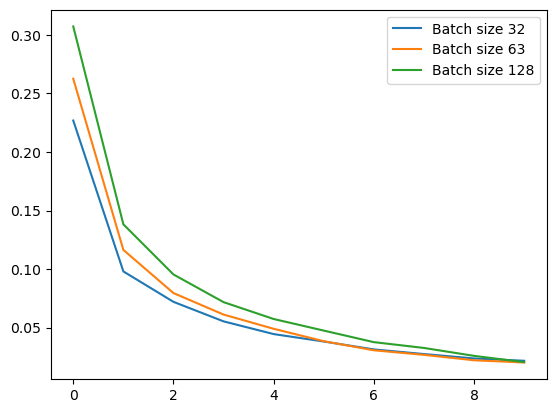

In [39]:
for bs in batch_size:
    plt.plot(result[bs][0],label=f"Batch size {bs}")

#plt.xlabel("epoch")
#plt.ylabel("Average Training Loss")
plt.legend()
plt.show()

results:

이는 여러 배치 크기에 대한 실험 결과를 저장한 딕셔너리(dictionary)입니다.

bs:

bs는 배치 크기를 나타내는 변수입니다. 예를 들어, 32, 64, 128과 같이 여러 배치 크기에 대해 실험했다면, 각 배치 크기가 딕셔너리의 키(key) 역할을 합니다.

results[bs] = (loss_history, accuracy) -> (0, 1)

results[bs][0]:

이 표현은 튜플의 첫 번째 요소, 즉 loss_history 리스트를 의미합니다.

예를 들어, 만약 10 에폭 동안 학습을 했다면, 이 리스트에는 각 에폭마다 계산된 평균 손실 값 10개의 float 값이 저장되어 있을 것입니다.


### 코드 리팩토링 및 가독성 개선

In [60]:
def train_mode(model, train_loader, criter, optime,num_epoch=5):
    loss_history=[]
    for epoch in range(num_epoch):
        model.train()
        total_loss=0.0
        for batch,(data, target)in enumerate(train_loader):
            out=model(data)
            loss=criter(out,target)
            optime.zero_grad()
            loss.backward()
            optime.step()
            total_loss+=loss.item()
        avg_loss=total_loss/len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epoch}, Training Loss: {avg_loss:.4f}")
    return loss_history


In [97]:
def eval_mode(model, test_loader):
    #acc_history=[]
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for data, target in test_loader:
            out=model(data)
            pred=out.argmax(dim=1,keepdim=True)
            correct+=pred.eq(target.view_as(pred)).sum().item()
            total+=data.size(0)
    acc=100.0*correct/total
    #acc_history.append(acc)
    return acc_history

##  디버깅 기법 및 에러 해결

In [100]:
#print문, 로깅 또는 파이썬 디버거(pdb) 등을 활용해 코드 흐름과 변수 값을 확인하는 방법을 연습합니다.
for batch, (idx,target) in enumerate(train_loader):
    out=model(data)
    loss=criter(out, target)
    optim.zero_grad()
    if batch==0:
        print(f"First batch output: {out[0]}")
        print(f"First batch loss: {loss.item()}")
    loss.backward()
    optim.step()
    total_loss+=loss.item()
#이걸로 교체시 디버그가능    

NameError: name 'data' is not defined

# 미니 배치 학습 최적화

In [103]:
tranform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_data=datasets.MNIST(root='/data',train=True, download=True, transform=tranform)
test_data=datasets.MNIST(root='/data',train=False,download=True,transform=tranform)

batch_size=[32,64,128]
result={}
num_epoch=10

for bs in batch_size:
    print(f"\n--- Training with batch size: {bs} ---")
    train_loader=DataLoader(train_data, batch_size=bs,shuffle=True)
    test_loader=DataLoader(test_data, batch_size=bs, shuffle=False)
    
    model=Model()
    criter=nn.CrossEntropyLoss()
    optims=optim.Adam(model.parameters(), lr=0.001)

    loss_history=train_mode(model, train_loader, criter, optims,num_epoch)
    accuracy_history=eval_mode(model, test_loader)
    accuracy=eval_mode(model, test_loader)
    result[bs]=(loss_history, accuracy)
    print(f"Test Accuracy with batch size {bs}: {accuracy:.2f}%")


--- Training with batch size: 32 ---
Epoch 1/10, Training Loss: 0.2300
Epoch 2/10, Training Loss: 0.1015
Epoch 3/10, Training Loss: 0.0736
Epoch 4/10, Training Loss: 0.0562
Epoch 5/10, Training Loss: 0.0446
Epoch 6/10, Training Loss: 0.0373
Epoch 7/10, Training Loss: 0.0326
Epoch 8/10, Training Loss: 0.0274
Epoch 9/10, Training Loss: 0.0241
Epoch 10/10, Training Loss: 0.0232


NameError: name 'acc_history' is not defined

In [ ]:
for bs in batch_size:
    plt.plot(result[bs][0],label=f"Batch size {bs}")

plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 예: accuracy_history에 에폭마다 테스트 정확도가 저장되어 있다고 가정 (예: [85.2, 87.6, 88.5, ...])
epochs = range(1, len(accuracy_history) + 1)
plt.plot(epochs, accuracy_history, marker='o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()


In [ ]:
plt.plot(epochs, train_accuracy_history, marker='o', label='Train Accuracy')
plt.plot(epochs, test_accuracy_history, marker='s', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.show()


# scheduler를 써서 학습조정

모델 및 데이터 준비:

SimpleMNIST 클래스는 MNIST 이미지를 1차원 벡터로 변환한 후, 두 개의 완전 연결층을 통해 분류합니다.

MNIST 데이터셋은 지정된 전처리를 통해 불러와지고, DataLoader를 사용해 배치 단위로 로딩됩니다.

학습 함수 (train_with_scheduler):

각 에폭마다 모델을 학습 모드로 전환하고, 모든 배치를 순회하면서 forward pass, 손실 계산, backward pass, 그리고 파라미터 업데이트를 수행합니다.

에폭마다 평균 손실, 현재 학습률, 테스트 정확도를 기록합니다.

마지막에 scheduler.step()을 호출해 StepLR 스케줄러에 의해 학습률이 업데이트됩니다.

여기서는 매 5 에폭마다 학습률을 현재 값의 0.5배로 줄입니다.

In [4]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader as loder
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [6]:
class simple(nn.Module):
    def __init__(self):
        super(simple,self).__init__()
        self.fc1=nn.Linear(28*28, 128)
        self.fc2=nn.Linear(128, 10)
    def forward(self, x):
        x=x.view(-1,28*28)
        x=torch.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [10]:
#eval
def eval_mode(model, test_loader):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for data, target in test_loader:
            out=model(data)
            pred=out.argmax(dim=1, keepdim=True)
            correct+=pred.eq(target.view_as(pred)).sum().item()
            total+=data.size(0)
    return 100.0*correct/total

In [64]:
def train_schedule(model, train_loader,test_loader, criter,oprimy, schedule, num_epoch=10):
    loss_history=[]
    lr_history=[]
    test_acc_history=[]
    for epoch in range(num_epoch):
        model.train()
        total_loss=0.0
        for data, target in train_loader:
            optimy.zero_grad()
            out=model(data)
            loss=criter(out,target)
            loss.backward()
            optimy.step()
            total_loss+=loss.item()
        avg_loss=total_loss/len(train_loader)
        loss_history.append(avg_loss)
        
               
        # 현재 학습률 기록 (optimizer의 첫 번째 param group 사용)
        current_lr = optimy.param_groups[0]['lr']
        lr_history.append(current_lr)

        test_acc=eval_mode(model, test_loader)
        test_acc_history.append(test_acc)
        print(f"Epoch {epoch+1}/{num_epoch}, Loss: {avg_loss:.4f}, LR: {current_lr:.6f}, Test Acc: {test_acc:.2f}%")


        # StepLR 스케줄러: 매 지정된 에폭마다 학습률 감소
        schedule.step()

    return loss_history, lr_history, test_acc_history


In [66]:
transform=transforms.Compose([
    transforms.ToTensor(),transforms.Normalize((0.1303,),(0.3081,))
])
train_data=datasets.MNIST(root="./data", train=True,download=True, transform=transform)
test_data=datasets.MNIST(root='./data',train=False,download=True, transform=transform)

train_loader=loder(train_data,batch_size=64, shuffle=True)
test_loader=loder(test_data,batch_size=1000,shuffle=True)

In [118]:
model=simple()
criter=nn.CrossEntropyLoss()
optimy=optim.Adam(model.parameters(),lr=0.001)

#schedule=optim.lr_scheduler.StepLR(optimy,step_size=5,gamma=0.5)
#schedule=optim.lr_scheduler.ExponentialLR(optimy, gamma=0.95)
#schedule=optim.lr_scheduler.CosineAnnealingLR(optimy,T_max=10,eta_min=0)
#shedule=optim.lr_scheduler.ReduceLROnPlateau(optimy, mode='min',factor=0.1, patience=3)
schedeul=optim.lr_scheduler.MultiStepLR(optimy, milestones=[30,80],gamma=0.1)


num_epoch=10
loss_history,lr_history, test_acc_history=train_schedule(model, train_loader, test_loader, criter, optimy,schedule,num_epoch=num_epoch)
epoch=range(1,num_epoch+1)

Epoch 1/10, Loss: 0.2569, LR: 0.001000, Test Acc: 96.30%
Epoch 2/10, Loss: 0.1108, LR: 0.001000, Test Acc: 97.04%
Epoch 3/10, Loss: 0.0766, LR: 0.001000, Test Acc: 97.17%
Epoch 4/10, Loss: 0.0590, LR: 0.001000, Test Acc: 97.41%
Epoch 5/10, Loss: 0.0486, LR: 0.001000, Test Acc: 97.78%
Epoch 6/10, Loss: 0.0389, LR: 0.001000, Test Acc: 97.72%
Epoch 7/10, Loss: 0.0294, LR: 0.001000, Test Acc: 97.77%
Epoch 8/10, Loss: 0.0247, LR: 0.001000, Test Acc: 97.72%
Epoch 9/10, Loss: 0.0234, LR: 0.001000, Test Acc: 97.87%
Epoch 10/10, Loss: 0.0196, LR: 0.001000, Test Acc: 97.80%


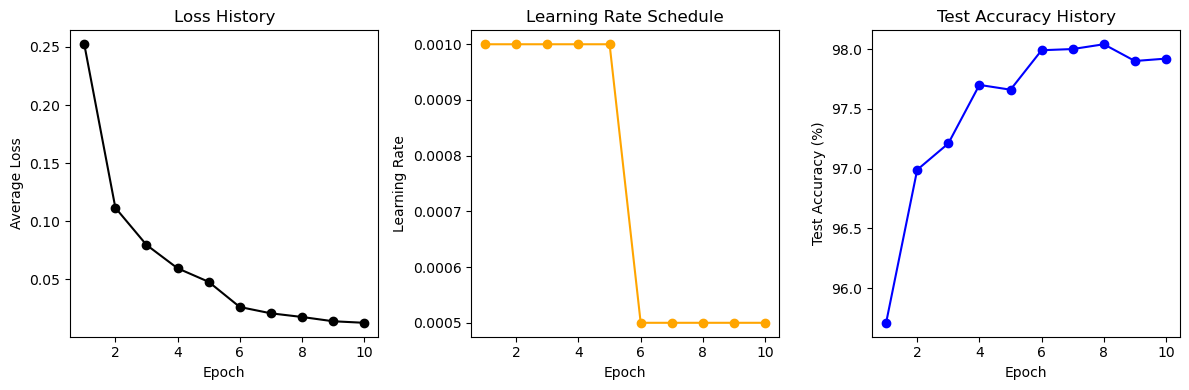

In [100]:
#StepLR
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(epoch,loss_history, marker='o', color='black')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss History')

plt.subplot(1,3,2)
plt.plot(epoch,lr_history,marker='o',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.subplot(1,3,3)
plt.plot(epoch, test_acc_history, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy History')

plt.tight_layout()
plt.show()

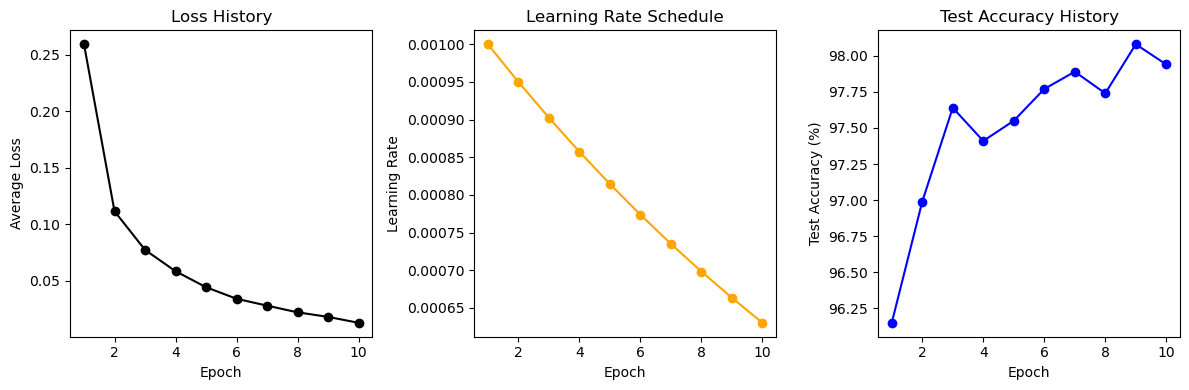

In [104]:
#ExponentialLR
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(epoch,loss_history, marker='o', color='black')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss History')

plt.subplot(1,3,2)
plt.plot(epoch,lr_history,marker='o',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.subplot(1,3,3)
plt.plot(epoch, test_acc_history, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy History')

plt.tight_layout()
plt.show()

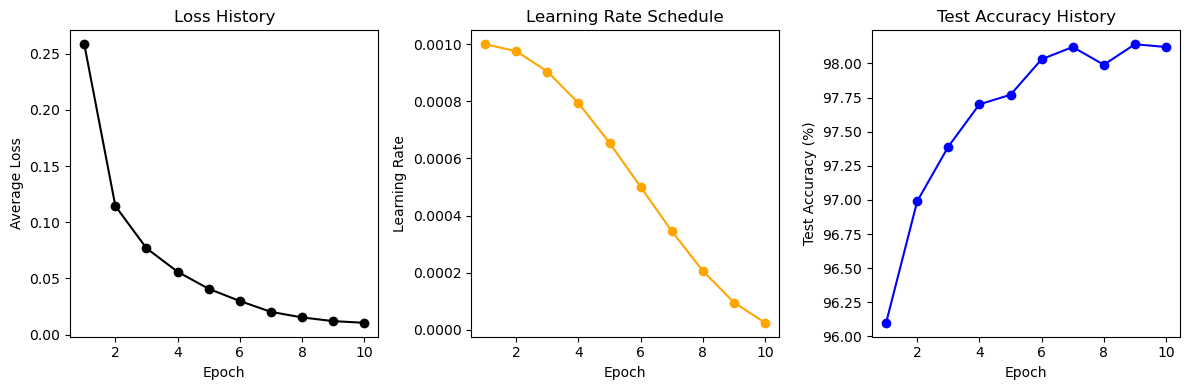

In [108]:
#CosineAnnealingLR
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(epoch,loss_history, marker='o', color='black')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss History')

plt.subplot(1,3,2)
plt.plot(epoch,lr_history,marker='o',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.subplot(1,3,3)
plt.plot(epoch, test_acc_history, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy History')

plt.tight_layout()
plt.show()

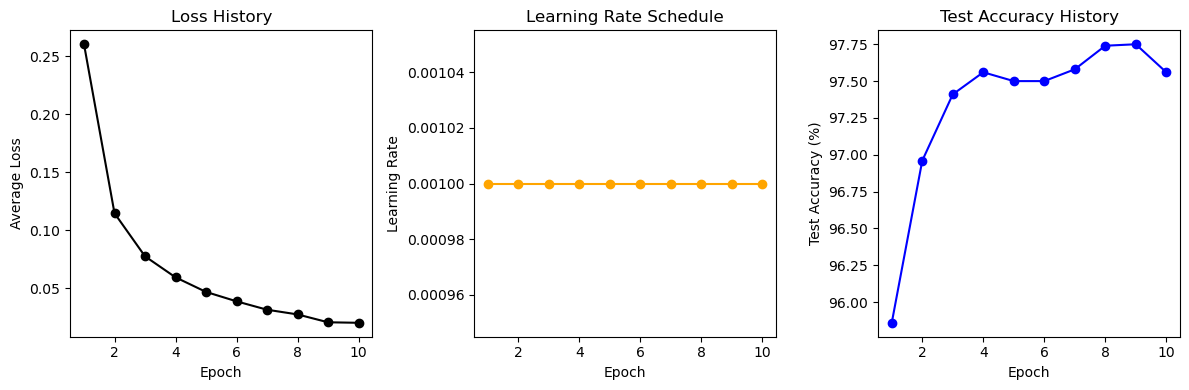

In [114]:
#ReduceLROnPlateau

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(epoch,loss_history, marker='o', color='black')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss History')

plt.subplot(1,3,2)
plt.plot(epoch,lr_history,marker='o',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.subplot(1,3,3)
plt.plot(epoch, test_acc_history, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy History')

plt.tight_layout()
plt.show()

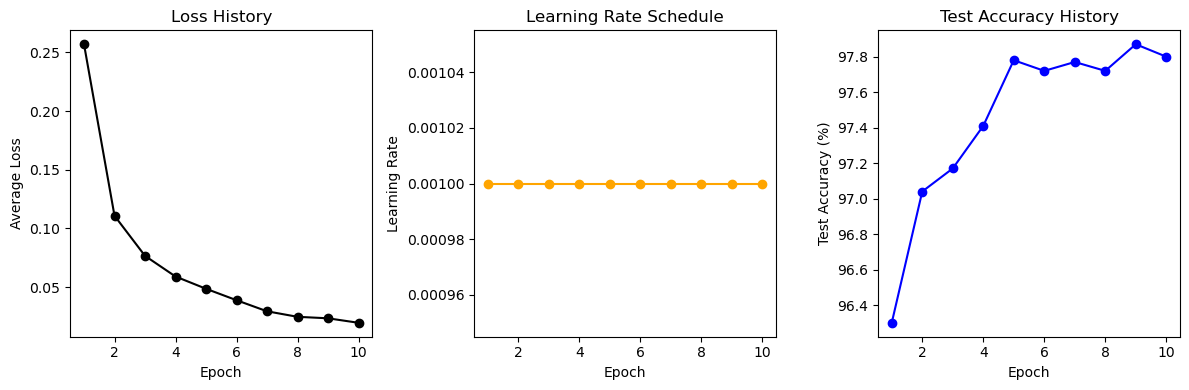

In [120]:
#MultiStepLR

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(epoch,loss_history, marker='o', color='black')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss History')

plt.subplot(1,3,2)
plt.plot(epoch,lr_history,marker='o',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.subplot(1,3,3)
plt.plot(epoch, test_acc_history, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy History')

plt.tight_layout()
plt.show()

In [84]:
#StepLR
'''작동 원리:
일정 에폭마다(또는 배치마다) 현재 학습률에 지정된 감쇠 계수(gamma)를 곱해 학습률을 줄입니다.

주요 매개변수:

step_size: 몇 에폭마다 학습률을 감소시킬지 지정합니다.

gamma: 감소시킬 비율 (예: 0.5면, 지정된 에폭마다 학습률이 절반이 됩니다)'''

schedule=optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)

TypeError: module is not an Optimizer

In [86]:
#ExponentialLR
'''작동 원리:
매 에폭마다 학습률에 일정한 지수 감쇠 계수를 곱해 학습률을 점진적으로 감소시킵니다.

주요 매개변수:

gamma: 매 에폭마다 학습률에 곱할 값.'''
schedule=optim.lr_scheduler.ExponentialLR(optim, gamma=0.95)

AttributeError: module 'torch.optim.lr_scheduler' has no attribute 'ExponentionalLR'

In [88]:
#CosineAnnealingLR
'''작동 원리:
학습률을 코사인 함수 모양으로 변화시킵니다. 보통 초반에는 높은 학습률로 시작해서 점차 낮아지며, 마지막에는 아주 낮은 학습률로 수렴합니다.

주요 매개변수:

T_max: 주기의 길이 (에폭 수)를 지정합니다.

eta_min: 학습률의 최솟값.'''
schedule=optim.lr_scheduler.CosineAnnealingLR(optim,T_max=10,eta_min=0)

'''→ 10 에폭 주기로 학습률이 코사인 곡선 형태로 감소하며, 최종적으로 0에 가까워집니다.'''

TypeError: module is not an Optimizer

In [ ]:
#ReduceLROnPlateau
'''작동 원리:
특정 평가 지표(예: validation loss)가 개선되지 않을 때 학습률을 감소시킵니다.

주요 매개변수:

mode: 'min' 또는 'max'를 지정하여, 모니터링하는 지표가 최소화되어야 하는지 혹은 최대화되어야 하는지를 설정합니다.

factor: 학습률을 감소시킬 비율.

patience: 지표가 개선되지 않는 에폭 수.'''
shedule=optim.lr_shcduler.ReduceLROnPlateau(optim, mode='min',factor=0.1, patience=3)

'''→ validation loss가 3 에폭 동안 개선되지 않으면 학습률을 0.1배로 줄입니다.
 '''

In [ ]:
#MultiStepLR
'''작동 원리:
지정된 에폭 리스트에 도달할 때마다 학습률을 특정 비율로 감소시킵니다.

주요 매개변수:

milestones: 학습률을 감소시킬 에폭 번호들의 리스트.

gamma: 감소 비율.'''

schedeul=optim.lr_sheduler.MultiStepLR(optim, milestones=[30,80],gamma=0.1)

'''→ 30 에폭과 80 에폭에 학습률을 각각 0.1배로 줄입니다.'''



plt.subplot(1, 3, 1)은 1행 3열의 첫 번째 위치,

plt.subplot(1, 3, 2)는 두 번째 위치,

plt.subplot(1, 3, 3)는 세 번째 위치(오른쪽 끝)를 의미합니다.

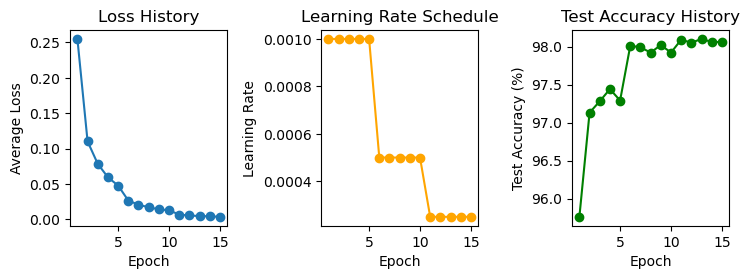

In [28]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
# 손실 곡선
plt.subplot(2, 4, 1)  #(서브플롯을 배치할 행(row),서브플롯을 배치할 열(column),현재 활성화할 서브플롯의 인덱스입니다. 인덱스는 1부터 시작하며, 여기서는 1행 3열의 그리드에서 세 번째, 즉 오른쪽 끝의 서브플롯을 선택하는 것을 의미합니다. )
plt.plot(epochs, loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss History')

# 학습률 변화
plt.subplot(2, 4, 2)
plt.plot(epochs, lr_history, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# 테스트 정확도
plt.subplot(2, 4, 3)
plt.plot(epochs, test_acc_history, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy History')

plt.tight_layout()
plt.show()